In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import sys
import os

from tensorflow import keras
from matplotlib import pyplot as plt

from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as k
import keras

In [14]:
transformation_ratio = 0.20

datagen = ImageDataGenerator(rescale=1. / 255,
                             validation_split = 0.2,
                             rotation_range=transformation_ratio,
                             shear_range=transformation_ratio,
                             zoom_range=transformation_ratio,
                             cval=transformation_ratio,
                             horizontal_flip=True,
                             vertical_flip=False)

In [15]:
# load and iterate training dataset
train = datagen.flow_from_directory("test-case-1-dataset/images/images", 
                                       target_size=(224,224), 
                                       color_mode='rgb', 
                                       class_mode="categorical",
                                       batch_size=12,
                                       subset = "training")


# Validation Data
val = datagen.flow_from_directory('test-case-1-dataset/images/images',
                                     target_size=(224,224),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=12,
                                     subset='validation')


# load and iterate test dataset
test = datagen.flow_from_directory("test-case-1-dataset/validation/validation", 
                                      target_size=(224,224), 
                                      color_mode='rgb', 
                                      class_mode="categorical")

Found 28075 images belonging to 4 classes.
Found 7018 images belonging to 4 classes.
Found 122 images belonging to 4 classes.


(12, 224, 224, 3)


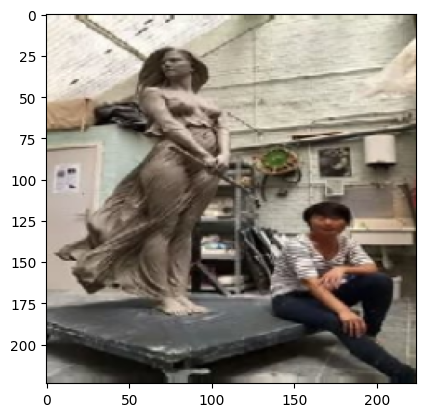

(12, 224, 224, 3)


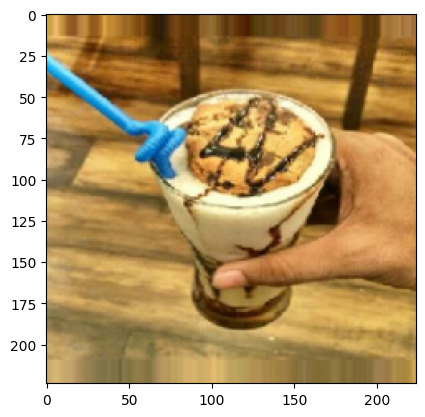

(12, 224, 224, 3)


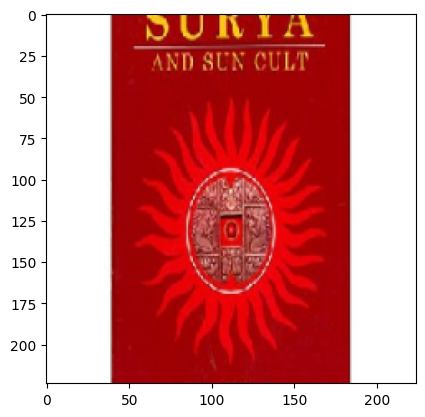

(12, 224, 224, 3)


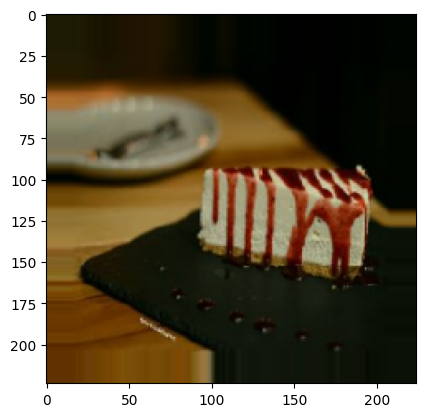

(12, 224, 224, 3)


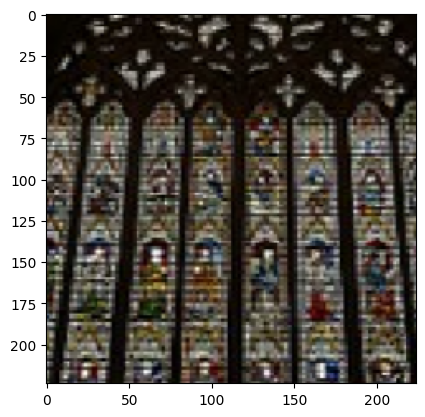

In [16]:
for _ in range(5):
    img, label = train.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

In [17]:
base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

58889256/58889256 [==============================] - 24s 0us/step


In [18]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
# Freeze base model
base_model.trainable = False

In [20]:
# Create inputs with correct shape
inputs = Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = Flatten()(x)

# Add a hidden layer
x = Dense(256, activation='relu')(x)

# Add a dropout layer
x = Dropout(.5)(x)

# Add final dense layer
outputs = Dense(4, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = Model(inputs, outputs)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21,138,500
Trainable params: 6,423,812
Non-trai

In [22]:
model.compile(loss='categorical_crossentropy',
              metrics=["accuracy"],
             optimizer = 'nadam')

In [23]:
history = model.fit_generator(generator = train,
                              steps_per_epoch=train.samples/train.batch_size,
                              epochs=16,
                              validation_data=val,
                              validation_steps=test.samples/test.batch_size,
)

Epoch 1/16


/var/folders/42/3d9r3rcx2vgd6bmrbmhv51k40000gn/T/ipykernel_12256/3248186868.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train,
2023-05-30 16:58:22.163979: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 165/2339 [=>............................] - ETA: 38:15 - loss: 1.0879 - accuracy: 0.6207

/opt/miniconda3/envs/snakes/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1359/2339 [================>.............] - ETA: 17:16 - loss: 0.6957 - accuracy: 0.7470

/opt/miniconda3/envs/snakes/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


2339/2339 [==============================] - 2461s 1s/step - loss: 0.6377 - accuracy: 0.7682 - val_loss: 0.4943 - val_accuracy: 0.8125
Epoch 2/16
2339/2339 [==============================] - 2591s 1s/step - loss: 0.5114 - accuracy: 0.8126 - val_loss: 0.5103 - val_accuracy: 0.8750
Epoch 3/16
2339/2339 [==============================] - 2562s 1s/step - loss: 0.4636 - accuracy: 0.8315 - val_loss: 0.5466 - val_accuracy: 0.7917
Epoch 4/16
2339/2339 [==============================] - 2549s 1s/step - loss: 0.4387 - accuracy: 0.8438 - val_loss: 0.6571 - val_accuracy: 0.7292
Epoch 5/16
2339/2339 [==============================] - 2925s 1s/step - loss: 0.4242 - accuracy: 0.8459 - val_loss: 0.5168 - val_accuracy: 0.7917
Epoch 6/16
2339/2339 [==============================] - 2568s 1s/step - loss: 0.4040 - accuracy: 0.8567 - val_loss: 0.5447 - val_accuracy: 0.8333
Epoch 7/16
2339/2339 [==============================] - 2488s 1s/step - loss: 0.3943 - accuracy: 0.8572 - val_loss: 0.3232 - val_accura

In [26]:
model.evaluate(test, steps=test.samples/test.batch_size)

3/3 [==============================] - 11s 3s/step - loss: 0.3872 - accuracy: 0.9016


[0.3871710002422333, 0.9016393423080444]

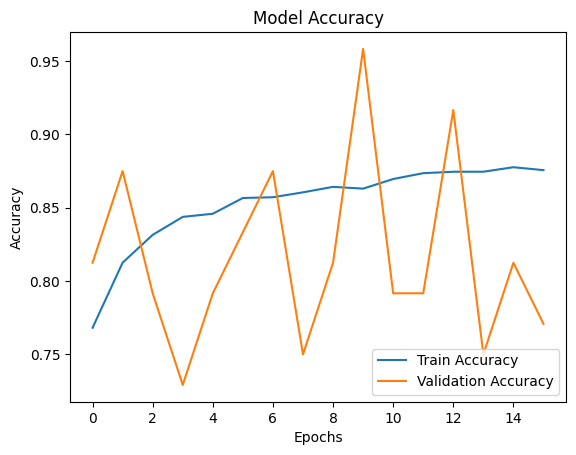

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy','Validation Accuracy'], loc = 'lower right')

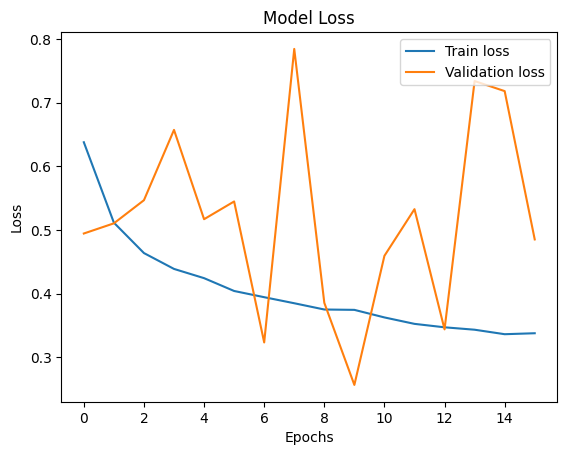

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train loss','Validation loss'], loc = 'upper right')

In [27]:
model.save('image_classifier.h5')